<img src="https://raw.githubusercontent.com/Sengsathit/OCR_data_scientist_assets/main/header_vision_transformer.png" alt="Alternative text" />

# Introduction

Ce notebook a pour objectif de réaliser un Proof of Concept (`PoC`) sur l'architecture Vision Transformer (`ViT`), dans le but d'évaluer ses performances et ses capacités à résoudre des problèmes de classification d'images. En nous appuyant sur le modèle `ViT-base-patch16-224`, nous allons analyser comment cette architecture, fondée sur les mécanismes d'attention des transformers, peut rivaliser avec ou surpasser les approches traditionnelles comme les Convolutional Neural Networks (`CNN`).

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from PIL import Image
from sklearn.metrics import accuracy_score
from datasets import Dataset


# Configurer Pandas pour un affichage complet du contenu des colonnes
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.rcParams['figure.facecolor'] = '#FFFCF7'    # Définir la couleur de fond de la figure
plt.rcParams['axes.facecolor'] = '#FFFCF7'      # Définir la couleur de fond des axes

/Users/sengsathit/Apprentissages/OpenClassrooms/Projets/OCR_data_scientist_projet_08/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chargement des données

In [2]:
df = pd.read_csv('../datasets/flipkart/flipkart_cleaned.csv')
images_path = '../datasets/flipkart/images/'

# Ajouter les chemins des images et les catégories au DataFrame
df['image_path'] = images_path + df['image']
df = df[['image_path', 'image', '_category']].rename(columns={'_category': 'label'})

# S'assurer que les labels sont des entiers (le modèle ne supporte pas de labels sous forme de chaînes de caractères)
label2id = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label2id)

# Préparation des données

Séparation du dataset original en DataFrame d'entraînement, de validation et de test.

In [3]:
# Diviser le dataset d'origine en train et test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Diviser df_train en train et validation
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42, stratify=df_train['label'])

Transformation des DataFrame en dataset compatible avec Hugging Face

In [4]:
# Conversion en datasets Hugging Face
train_dataset = Dataset.from_pandas(df_train)
validation_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

Préprocessing d'imagess et Data Augmentation avec quelques paramètres de transformation

In [5]:
# Configurer Albumentations pour la data augmentation (utilisé uniquement pour train_dataset)
augmentations = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5)
])

# Chargement du preprocesseur pour normaliser et redimensionner les images avant de les passer au modèle
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Fonction de prétraitement avec augmentation pour le dataset d'entraînement
def preprocess_train(data):
    augmented_images = []
    for img_path in data['image_path']:
        img = Image.open(img_path).convert("RGB")
        img_array = np.array(img)

        # Appliquer les augmentations uniquement pour les images du dataset d'entraînement
        augmented = augmentations(image=img_array)['image']

        img_augmented = Image.fromarray(augmented)
        augmented_images.append(img_augmented)

    # Appliquer le preprocessing du modèle ViT
    inputs = image_processor(augmented_images, return_tensors="pt")
    inputs['labels'] = data['label']
    return inputs

# Fonction de prétraitement sans augmentation pour le dataset de test
def preprocess_test(data):
    images = [Image.open(img_path).convert("RGB") for img_path in data['image_path']]
    inputs = image_processor(images, return_tensors="pt")
    inputs['labels'] = data['label']
    return inputs


# Appliquer la fonction de prétraitement pour le dataset d'entraînement avec augmentation
train_dataset = train_dataset.map(preprocess_train, batched=True)

# Appliquer la fonction de prétraitement sans augmentation pour les datasets de validation et de test
validation_dataset = validation_dataset.map(preprocess_test, batched=True)
test_dataset = test_dataset.map(preprocess_test, batched=True)

Map: 100%|██████████| 210/210 [00:01<00:00, 127.54 examples/s]


# Entraînement du modèle ViT-B/16

Chargement du modèle

In [6]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224', 
    num_labels=len(df['label'].unique()),
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entraînement du modèle grâce au Trainer de Hugging Face, cela en tenant compte d'arguments d'entraînement

In [7]:
# Arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./train_results',             # Répertoire pour sauvegarder le meilleur modèle
    logging_dir='./train_logs',               # Répertoire pour les logs de performance
    eval_strategy="epoch",                    # Évaluer à chaque époque
    save_strategy="epoch",                    # Sauvegarder à chaque époque
    save_total_limit=1,                       # Ne conserver que le meilleur modèle
    metric_for_best_model="eval_loss",        # Utiliser la perte d'évaluation pour déterminer le meilleur modèle
    load_best_model_at_end=True,              # Charger le meilleur modèle à la fin de l'entraînement
    per_device_train_batch_size=16,           # Taille des batches pour l'entraînement
    per_device_eval_batch_size=16,            # Taille des batches pour l'évaluation
    num_train_epochs=15,                      # Nombre d'époques d'entraînement
    logging_steps=10,                         # Fréquence d'enregistrement des logs
    learning_rate=5e-5,
    warmup_steps=500                          # Nombre d'étapes de "warmup" pour ajuster progressivement le learning rate
)

# Fonction pour récupérer l'accuracy lors de la phase d'entraînement
def compute_metrics(prediction):
    preds = np.argmax(prediction.predictions, axis=1)
    acc = accuracy_score(prediction.label_ids, preds)
    return {"accuracy": acc}

# Objet trainer pour entraîner le modèle en tenant compte des paramètres d'apprentissage et de test
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics
)

# Lancer l'entraînement
trainer.train()

  2%|▏         | 10/600 [00:16<15:01,  1.53s/it]

{'loss': 2.0189, 'grad_norm': 9.726452827453613, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.25}


  3%|▎         | 20/600 [00:31<14:36,  1.51s/it]

{'loss': 2.0796, 'grad_norm': 8.752893447875977, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.5}


  5%|▌         | 30/600 [00:46<14:17,  1.50s/it]

{'loss': 2.0689, 'grad_norm': 8.622718811035156, 'learning_rate': 3e-06, 'epoch': 0.75}


  7%|▋         | 40/600 [01:00<10:00,  1.07s/it]

{'loss': 2.014, 'grad_norm': 12.172362327575684, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.0}


                                                
  7%|▋         | 40/600 [01:13<10:00,  1.07s/it]

{'eval_loss': 2.0428812503814697, 'eval_accuracy': 0.1761904761904762, 'eval_runtime': 13.2383, 'eval_samples_per_second': 15.863, 'eval_steps_per_second': 1.058, 'epoch': 1.0}


  8%|▊         | 50/600 [01:31<15:26,  1.69s/it]

{'loss': 1.8533, 'grad_norm': 8.024389266967773, 'learning_rate': 5e-06, 'epoch': 1.25}


 10%|█         | 60/600 [01:46<13:36,  1.51s/it]

{'loss': 1.9024, 'grad_norm': 8.341156005859375, 'learning_rate': 6e-06, 'epoch': 1.5}


 12%|█▏        | 70/600 [02:01<13:18,  1.51s/it]

{'loss': 1.6914, 'grad_norm': 8.714640617370605, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.75}


 13%|█▎        | 80/600 [02:14<09:09,  1.06s/it]

{'loss': 1.6344, 'grad_norm': 11.8134126663208, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}


                                                
 13%|█▎        | 80/600 [02:28<09:09,  1.06s/it]

{'eval_loss': 1.7189322710037231, 'eval_accuracy': 0.38571428571428573, 'eval_runtime': 13.3162, 'eval_samples_per_second': 15.77, 'eval_steps_per_second': 1.051, 'epoch': 2.0}


 15%|█▌        | 90/600 [02:45<14:23,  1.69s/it]

{'loss': 1.4603, 'grad_norm': 7.725675582885742, 'learning_rate': 9e-06, 'epoch': 2.25}


 17%|█▋        | 100/600 [03:01<12:36,  1.51s/it]

{'loss': 1.3253, 'grad_norm': 7.384763717651367, 'learning_rate': 1e-05, 'epoch': 2.5}


 18%|█▊        | 110/600 [03:16<13:08,  1.61s/it]

{'loss': 1.2163, 'grad_norm': 7.36618709564209, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.75}


 20%|██        | 120/600 [03:29<08:19,  1.04s/it]

{'loss': 1.0912, 'grad_norm': 10.321343421936035, 'learning_rate': 1.2e-05, 'epoch': 3.0}


                                                 
 20%|██        | 120/600 [03:42<08:19,  1.04s/it]

{'eval_loss': 1.2748180627822876, 'eval_accuracy': 0.6857142857142857, 'eval_runtime': 13.1159, 'eval_samples_per_second': 16.011, 'eval_steps_per_second': 1.067, 'epoch': 3.0}


 22%|██▏       | 130/600 [04:00<12:57,  1.65s/it]

{'loss': 0.8705, 'grad_norm': 5.823710918426514, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.25}


 23%|██▎       | 140/600 [04:14<11:21,  1.48s/it]

{'loss': 0.7973, 'grad_norm': 5.559782981872559, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.5}


 25%|██▌       | 150/600 [04:29<11:04,  1.48s/it]

{'loss': 0.6389, 'grad_norm': 5.365940570831299, 'learning_rate': 1.5e-05, 'epoch': 3.75}


 27%|██▋       | 160/600 [04:42<07:35,  1.03s/it]

{'loss': 0.657, 'grad_norm': 7.36571741104126, 'learning_rate': 1.6000000000000003e-05, 'epoch': 4.0}


                                                 
 27%|██▋       | 160/600 [05:14<07:35,  1.03s/it]

{'eval_loss': 0.8595283031463623, 'eval_accuracy': 0.7904761904761904, 'eval_runtime': 31.7119, 'eval_samples_per_second': 6.622, 'eval_steps_per_second': 0.441, 'epoch': 4.0}


 28%|██▊       | 170/600 [05:32<13:33,  1.89s/it]  

{'loss': 0.3692, 'grad_norm': 4.460859775543213, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.25}


 30%|███       | 180/600 [05:47<10:26,  1.49s/it]

{'loss': 0.3564, 'grad_norm': 4.773380279541016, 'learning_rate': 1.8e-05, 'epoch': 4.5}


 32%|███▏      | 190/600 [06:01<10:07,  1.48s/it]

{'loss': 0.3233, 'grad_norm': 3.2643349170684814, 'learning_rate': 1.9e-05, 'epoch': 4.75}


 33%|███▎      | 200/600 [06:15<06:56,  1.04s/it]

{'loss': 0.3272, 'grad_norm': 5.394101142883301, 'learning_rate': 2e-05, 'epoch': 5.0}


                                                 
 33%|███▎      | 200/600 [06:28<06:56,  1.04s/it]

{'eval_loss': 0.6081250309944153, 'eval_accuracy': 0.8333333333333334, 'eval_runtime': 13.5305, 'eval_samples_per_second': 15.52, 'eval_steps_per_second': 1.035, 'epoch': 5.0}


 35%|███▌      | 210/600 [06:46<10:53,  1.68s/it]

{'loss': 0.1594, 'grad_norm': 2.3900599479675293, 'learning_rate': 2.1e-05, 'epoch': 5.25}


 37%|███▋      | 220/600 [07:01<09:33,  1.51s/it]

{'loss': 0.1344, 'grad_norm': 1.502105474472046, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.5}


 38%|███▊      | 230/600 [07:16<09:11,  1.49s/it]

{'loss': 0.1223, 'grad_norm': 2.4010391235351562, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.75}


 40%|████      | 240/600 [07:29<06:18,  1.05s/it]

{'loss': 0.0941, 'grad_norm': 4.585350036621094, 'learning_rate': 2.4e-05, 'epoch': 6.0}


                                                 
 40%|████      | 240/600 [07:42<06:18,  1.05s/it]

{'eval_loss': 0.4700174331665039, 'eval_accuracy': 0.8476190476190476, 'eval_runtime': 13.1399, 'eval_samples_per_second': 15.982, 'eval_steps_per_second': 1.065, 'epoch': 6.0}


 42%|████▏     | 250/600 [08:00<09:40,  1.66s/it]

{'loss': 0.0384, 'grad_norm': 0.5083829760551453, 'learning_rate': 2.5e-05, 'epoch': 6.25}


 43%|████▎     | 260/600 [08:14<08:24,  1.48s/it]

{'loss': 0.0375, 'grad_norm': 0.39899224042892456, 'learning_rate': 2.6000000000000002e-05, 'epoch': 6.5}


 45%|████▌     | 270/600 [08:29<08:12,  1.49s/it]

{'loss': 0.0282, 'grad_norm': 1.0265703201293945, 'learning_rate': 2.7000000000000002e-05, 'epoch': 6.75}


 47%|████▋     | 280/600 [08:43<05:40,  1.06s/it]

{'loss': 0.0304, 'grad_norm': 0.2537252902984619, 'learning_rate': 2.8000000000000003e-05, 'epoch': 7.0}


                                                 
 47%|████▋     | 280/600 [08:56<05:40,  1.06s/it]

{'eval_loss': 0.42891091108322144, 'eval_accuracy': 0.8523809523809524, 'eval_runtime': 13.3604, 'eval_samples_per_second': 15.718, 'eval_steps_per_second': 1.048, 'epoch': 7.0}


 48%|████▊     | 290/600 [09:13<08:38,  1.67s/it]

{'loss': 0.0113, 'grad_norm': 0.18689727783203125, 'learning_rate': 2.9e-05, 'epoch': 7.25}


 50%|█████     | 300/600 [09:28<07:28,  1.49s/it]

{'loss': 0.0109, 'grad_norm': 0.15125200152397156, 'learning_rate': 3e-05, 'epoch': 7.5}


 52%|█████▏    | 310/600 [09:43<07:13,  1.49s/it]

{'loss': 0.0101, 'grad_norm': 0.38934171199798584, 'learning_rate': 3.1e-05, 'epoch': 7.75}


 53%|█████▎    | 320/600 [09:57<04:53,  1.05s/it]

{'loss': 0.0102, 'grad_norm': 0.5025586485862732, 'learning_rate': 3.2000000000000005e-05, 'epoch': 8.0}


                                                 
 53%|█████▎    | 320/600 [10:10<04:53,  1.05s/it]

{'eval_loss': 0.4149147868156433, 'eval_accuracy': 0.8571428571428571, 'eval_runtime': 13.1973, 'eval_samples_per_second': 15.912, 'eval_steps_per_second': 1.061, 'epoch': 8.0}


 55%|█████▌    | 330/600 [10:27<07:30,  1.67s/it]

{'loss': 0.0057, 'grad_norm': 0.14131364226341248, 'learning_rate': 3.3e-05, 'epoch': 8.25}


 57%|█████▋    | 340/600 [10:42<06:31,  1.51s/it]

{'loss': 0.0056, 'grad_norm': 0.05858670175075531, 'learning_rate': 3.4000000000000007e-05, 'epoch': 8.5}


 58%|█████▊    | 350/600 [10:57<06:21,  1.53s/it]

{'loss': 0.0047, 'grad_norm': 0.06809373199939728, 'learning_rate': 3.5e-05, 'epoch': 8.75}


 60%|██████    | 360/600 [11:11<04:15,  1.06s/it]

{'loss': 0.0047, 'grad_norm': 0.13855399191379547, 'learning_rate': 3.6e-05, 'epoch': 9.0}


                                                 
 60%|██████    | 360/600 [11:24<04:15,  1.06s/it]

{'eval_loss': 0.4108429551124573, 'eval_accuracy': 0.8571428571428571, 'eval_runtime': 13.2992, 'eval_samples_per_second': 15.79, 'eval_steps_per_second': 1.053, 'epoch': 9.0}


 62%|██████▏   | 370/600 [11:41<06:27,  1.69s/it]

{'loss': 0.0033, 'grad_norm': 0.04812423139810562, 'learning_rate': 3.7e-05, 'epoch': 9.25}


 63%|██████▎   | 380/600 [11:57<05:33,  1.52s/it]

{'loss': 0.0035, 'grad_norm': 0.07162127643823624, 'learning_rate': 3.8e-05, 'epoch': 9.5}


 65%|██████▌   | 390/600 [12:12<05:14,  1.50s/it]

{'loss': 0.0031, 'grad_norm': 0.04837175831198692, 'learning_rate': 3.9000000000000006e-05, 'epoch': 9.75}


 67%|██████▋   | 400/600 [12:25<03:30,  1.05s/it]

{'loss': 0.0031, 'grad_norm': 0.03792816773056984, 'learning_rate': 4e-05, 'epoch': 10.0}


                                                 
 67%|██████▋   | 400/600 [12:38<03:30,  1.05s/it]

{'eval_loss': 0.4150417447090149, 'eval_accuracy': 0.8714285714285714, 'eval_runtime': 13.2191, 'eval_samples_per_second': 15.886, 'eval_steps_per_second': 1.059, 'epoch': 10.0}


 68%|██████▊   | 410/600 [12:55<05:16,  1.67s/it]

{'loss': 0.0026, 'grad_norm': 0.036265160888433456, 'learning_rate': 4.1e-05, 'epoch': 10.25}


 70%|███████   | 420/600 [13:10<04:29,  1.50s/it]

{'loss': 0.0023, 'grad_norm': 0.03364383429288864, 'learning_rate': 4.2e-05, 'epoch': 10.5}


 72%|███████▏  | 430/600 [13:25<04:13,  1.49s/it]

{'loss': 0.0025, 'grad_norm': 0.03181006386876106, 'learning_rate': 4.3e-05, 'epoch': 10.75}


 73%|███████▎  | 440/600 [13:39<02:49,  1.06s/it]

{'loss': 0.0019, 'grad_norm': 0.039751723408699036, 'learning_rate': 4.4000000000000006e-05, 'epoch': 11.0}


                                                 
 73%|███████▎  | 440/600 [13:52<02:49,  1.06s/it]

{'eval_loss': 0.41805946826934814, 'eval_accuracy': 0.8714285714285714, 'eval_runtime': 13.4739, 'eval_samples_per_second': 15.586, 'eval_steps_per_second': 1.039, 'epoch': 11.0}


 75%|███████▌  | 450/600 [14:09<04:11,  1.68s/it]

{'loss': 0.0018, 'grad_norm': 0.027066102251410484, 'learning_rate': 4.5e-05, 'epoch': 11.25}


 77%|███████▋  | 460/600 [14:24<03:31,  1.51s/it]

{'loss': 0.0018, 'grad_norm': 0.017705900594592094, 'learning_rate': 4.600000000000001e-05, 'epoch': 11.5}


 78%|███████▊  | 470/600 [14:39<03:15,  1.51s/it]

{'loss': 0.0016, 'grad_norm': 0.023695293813943863, 'learning_rate': 4.7e-05, 'epoch': 11.75}


 80%|████████  | 480/600 [14:53<02:06,  1.05s/it]

{'loss': 0.0017, 'grad_norm': 0.036843426525592804, 'learning_rate': 4.8e-05, 'epoch': 12.0}


                                                 
 80%|████████  | 480/600 [15:06<02:06,  1.05s/it]

{'eval_loss': 0.4226830005645752, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 13.2475, 'eval_samples_per_second': 15.852, 'eval_steps_per_second': 1.057, 'epoch': 12.0}


 82%|████████▏ | 490/600 [15:23<03:04,  1.68s/it]

{'loss': 0.0016, 'grad_norm': 0.02230418100953102, 'learning_rate': 4.9e-05, 'epoch': 12.25}


 83%|████████▎ | 500/600 [15:38<02:30,  1.50s/it]

{'loss': 0.0013, 'grad_norm': 0.01936035417020321, 'learning_rate': 5e-05, 'epoch': 12.5}


 85%|████████▌ | 510/600 [15:54<02:15,  1.50s/it]

{'loss': 0.0013, 'grad_norm': 0.016909176483750343, 'learning_rate': 4.5e-05, 'epoch': 12.75}


 87%|████████▋ | 520/600 [16:07<01:24,  1.05s/it]

{'loss': 0.0013, 'grad_norm': 0.027983224019408226, 'learning_rate': 4e-05, 'epoch': 13.0}


                                                 
 87%|████████▋ | 520/600 [16:20<01:24,  1.05s/it]

{'eval_loss': 0.4268835186958313, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 13.3128, 'eval_samples_per_second': 15.774, 'eval_steps_per_second': 1.052, 'epoch': 13.0}


 88%|████████▊ | 530/600 [16:38<01:58,  1.69s/it]

{'loss': 0.0011, 'grad_norm': 0.018314341083168983, 'learning_rate': 3.5e-05, 'epoch': 13.25}


 90%|█████████ | 540/600 [16:53<01:30,  1.50s/it]

{'loss': 0.0011, 'grad_norm': 0.018287673592567444, 'learning_rate': 3e-05, 'epoch': 13.5}


 92%|█████████▏| 550/600 [17:08<01:14,  1.49s/it]

{'loss': 0.0012, 'grad_norm': 0.01407625712454319, 'learning_rate': 2.5e-05, 'epoch': 13.75}


 93%|█████████▎| 560/600 [17:21<00:42,  1.05s/it]

{'loss': 0.0011, 'grad_norm': 0.02715863287448883, 'learning_rate': 2e-05, 'epoch': 14.0}


                                                 
 93%|█████████▎| 560/600 [17:35<00:42,  1.05s/it]

{'eval_loss': 0.4296506643295288, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 13.2169, 'eval_samples_per_second': 15.889, 'eval_steps_per_second': 1.059, 'epoch': 14.0}


 95%|█████████▌| 570/600 [17:52<00:50,  1.68s/it]

{'loss': 0.0011, 'grad_norm': 0.016643481329083443, 'learning_rate': 1.5e-05, 'epoch': 14.25}


 97%|█████████▋| 580/600 [18:07<00:30,  1.51s/it]

{'loss': 0.001, 'grad_norm': 0.013671268709003925, 'learning_rate': 1e-05, 'epoch': 14.5}


 98%|█████████▊| 590/600 [18:23<00:15,  1.53s/it]

{'loss': 0.001, 'grad_norm': 0.017962392419576645, 'learning_rate': 5e-06, 'epoch': 14.75}


100%|██████████| 600/600 [18:36<00:00,  1.06s/it]

{'loss': 0.001, 'grad_norm': 0.018146749585866928, 'learning_rate': 0.0, 'epoch': 15.0}


                                                 
100%|██████████| 600/600 [18:51<00:00,  1.06s/it]

{'eval_loss': 0.43058210611343384, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 13.2256, 'eval_samples_per_second': 15.878, 'eval_steps_per_second': 1.059, 'epoch': 15.0}


100%|██████████| 600/600 [18:52<00:00,  1.89s/it]

{'train_runtime': 1132.8042, 'train_samples_per_second': 8.342, 'train_steps_per_second': 0.53, 'train_loss': 0.42412046999049685, 'epoch': 15.0}


TrainOutput(global_step=600, training_loss=0.42412046999049685, metrics={'train_runtime': 1132.8042, 'train_samples_per_second': 8.342, 'train_steps_per_second': 0.53, 'total_flos': 7.323321186929664e+17, 'train_loss': 0.42412046999049685, 'epoch': 15.0})

# Résultats de l'entraînement

## Visualisation de la validation au fil des epochs

In [8]:
# Récupérer les métriques après l'entraînement
log_history = trainer.state.log_history

# Extraire les métriques de validation pour chaque époque
validation_loss_values = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
validation_accuracy_values = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]

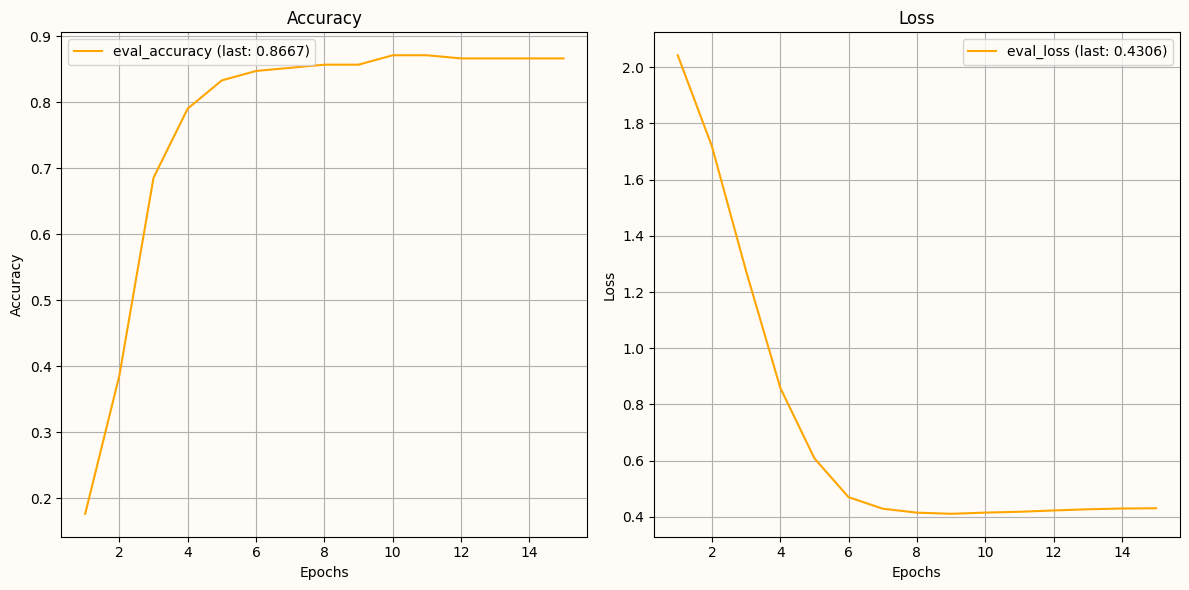

In [9]:
# Fonctions pour tracer l'historique des métrics de l'entraînement
def plot_metrics():
    epochs = range(1, len(validation_loss_values) + 1)
    
    plt.figure(figsize=(12, 6))
    
    # Graphique pour l'accuracy
    plt.subplot(1, 2, 1)
    last_acc = validation_accuracy_values[-1]
    plt.plot(epochs, validation_accuracy_values, label=f"eval_accuracy (last: {last_acc:.4f})", color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.grid(True)
    plt.legend()

    # Graphique pour le loss
    plt.subplot(1, 2, 2)
    last_loss = validation_loss_values[-1]
    plt.plot(epochs, validation_loss_values, label=f"eval_loss (last: {last_loss:.4f})", color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_metrics()

## Évaluation du modèle sur le jeu de données de test

In [10]:
# Évaluation du trainer qui contient le modèle optimisé
evaluation = trainer.evaluate(test_dataset)
print('\nTEST')
print('Accuracy : {:.4f}'.format(evaluation['eval_accuracy']))
print('Loss : {:.4f}'.format(evaluation['eval_loss']))

100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


TEST
Accuracy : 0.8524
Loss : 0.4756
